In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [52]:
#data = pd.read_csv('/Users/MikeMargolis/Downloads/train.csv')
#For person MAC
data= pd.read_csv('train.csv')

In [53]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


### Observing the data and first thoughts
- label and pixel values 
- first column is Y value next 784 are pixel values for each row, Good
- would be easier if we transpose the data to have Y Values in the first row
- if rows are 784 from a matrix, it must be a 28 x 28 matrix of neurons, sqrt(784) = 28
- need the dimension of the data m (rows) and n (columns)
- probably have to make a numpy array to use my equations
- split into train and test
- have to transpose some matrixies to use matrix algebra
- Sigmoid Vs ReLU, Sigmoid is better but harder to undo, ReLU works and I can get the derivative easier it when I get to backprop


## Method
- Use input layer of each row
    - 28 x 28 matrix of 784 nodes
- Use one hidden layer of 10 nodes
    - weights and biases of each node from input layer are passed to each 10 nodes in hidden layer
    - wieghts and biases will start at random values and update/correct after back propigation
    - weight matrix is 10 x 784
    - bias matric is 10 x 1
    - activation matrix is 784 x m
    - hidden layer matrix is 10 x m
- Acitivation in output layer is 10 hidden layer nodes passing info to each 10 nodes in output layer
- Use ReLU function and soft max to determine activation and final prediction
- Use back propigation to update parameters
    - first output to hidden layer
- Find difference between actual value and predicted value (error term)
- update weights using derivative of hidden layer weight function times predicted values 
- update bias term by average of the error term
    - hidden to input  layer
- new weights and bias function passed through derivative of ReLU function
- new weights and bias are updated by new weights and bias function
- Amount of update/adjustment in new terms is based on learning rate (alpha)
- run functions again using updated parameters
- Check accuracy on training dataset
- Apply gradient descent function test dataset to really test accuracy on unseen data

In [55]:
data = np.array(data)

In [56]:
m ,n = data.shape

In [57]:
np.random.shuffle(data)

- Randomize the data in-place

In [58]:
data_test = data[0:2000].T
Y_test = data_test[0]
X_test = data_test[1:n]
X_test = X_test / 255.

data_train = data[2000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [59]:
Y_train
#correct Y values that we will be predicting

array([3, 3, 7, ..., 6, 7, 7], dtype=int64)

In [60]:
Y_test

array([7, 1, 2, ..., 2, 7, 1], dtype=int64)

In [61]:
X_train[:,0].shape
#784 pixels, Good

(784,)

In [62]:
X_test[:,0].shape

(784,)

## Start the math and define parameters

In [63]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(H):
    return np.maximum(H, 0)

def softmax(H):
    A = np.exp(H) / sum(np.exp(H))
    return A

- We first started with randomizing weights and bias parameters
- The ReLU function will set all nodes to 0 if the obervation is 0, weight is too low or node does not not meet the bias threshold
- Soft max will tell hidden layer which output layer to select, each value (0,9) in the output layer will have a probability determined by the softmax function, the output node with the highest probability will be the machine's guess

### Forward Propigation

In [64]:
def forward_prop(W1, b1, W2, b2, X):
    H1 = W1.dot(X) + b1
    A1 = ReLU(H1)
    H2 = W2.dot(A1) + b2
    A2 = softmax(H2)
    return H1, A1, H2, A2

- H1 is just storing the input values from the 784 nodes
- H2 is our first pass to the hidden layer, assigning a weight and a bias to each node
- A1 is our hidden layer working with the ReLU function determining which values to send to the output layer 
- ReLU = Rectified Linear Units
- A2 is the output layer applying the softmax function to find the output node to select, will select node with the highest probability

### Set up Backward Propigation

In [65]:
def ReLU_deriv(H):
    return H > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

- starting back prop
- have to set up/undo the ReLU function to pass output layer to hidden layer
- derivative of the ReLU function is easy since its a zero slope for all negative/zero x-axis values and a constant slope of 1 for all positive x-axis values
- Use actual Y values to rework our forward prop and adjust coeffiecent (weights and biases) in forward prop functions
- need to fix Y to indicate values not be values called "one hot"
- for each row fnd the column with the specified Y values and set = 1 if they match
- then we have to flip the matrix we want the columns to be the example not each row

### Backward Propigation and Updating

In [66]:
def backward_prop(H1, A1, H2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dH2 = A2 - one_hot_Y
    dW2 = 1 / m * dH2.dot(A1.T)
    db2 = 1 / m * np.sum(dH2)
    dH1 = W2.T.dot(dH2) * ReLU_deriv(H1)
    dW1 = 1 / m * dH1.dot(X.T)
    db1 = 1 / m * np.sum(dH1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

### Setting up predictions and accuracy tests

In [67]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

### Gradient Descent and setting up function for running tests

In [68]:
def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        H1, A1, H2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(H1, A1, H2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 100 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2
        
        

### Running the tests on training dataset with 500 iterations and a learning rate of 10%

In [82]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.05, 10000)

Iteration:  0
[2 1 2 ... 2 2 1] [3 3 7 ... 6 7 7]
0.0977
Iteration:  100
[2 8 9 ... 6 7 8] [3 3 7 ... 6 7 7]
0.4947
Iteration:  200
[2 3 7 ... 6 7 8] [3 3 7 ... 6 7 7]
0.632175
Iteration:  300
[2 3 7 ... 6 7 8] [3 3 7 ... 6 7 7]
0.7069
Iteration:  400
[2 3 7 ... 6 7 8] [3 3 7 ... 6 7 7]
0.754575
Iteration:  500
[2 3 7 ... 6 7 8] [3 3 7 ... 6 7 7]
0.78635
Iteration:  600
[2 3 7 ... 6 7 7] [3 3 7 ... 6 7 7]
0.80945
Iteration:  700
[2 3 7 ... 6 7 7] [3 3 7 ... 6 7 7]
0.82375
Iteration:  800
[2 3 7 ... 6 7 7] [3 3 7 ... 6 7 7]
0.83525
Iteration:  900
[2 3 7 ... 6 7 7] [3 3 7 ... 6 7 7]
0.8442
Iteration:  1000
[2 3 7 ... 6 7 7] [3 3 7 ... 6 7 7]
0.850225
Iteration:  1100
[2 3 7 ... 6 7 7] [3 3 7 ... 6 7 7]
0.8553
Iteration:  1200
[2 3 7 ... 6 7 7] [3 3 7 ... 6 7 7]
0.859375
Iteration:  1300
[2 3 7 ... 6 7 7] [3 3 7 ... 6 7 7]
0.863325
Iteration:  1400
[2 3 7 ... 6 7 7] [3 3 7 ... 6 7 7]
0.8668
Iteration:  1500
[2 3 7 ... 6 7 7] [3 3 7 ... 6 7 7]
0.869325
Iteration:  1600
[2 3 7 ... 6 7 7] [

### Traning Data results and obeservations
- First random seed we get an accuracy of 84.5% after 500 iterations and learning rate of 10%
- Couple more random seeds with 1000 iterations best accuracy I got was 90%
- Random seed with 1000 iterations and a learning rate of 30% the best accuracy I got in sample was 90.25%
- Random seed with 10,000 iterations and a learning rate of .05 produced an accuracy of 92.48%
- pretty good 
- definetly beats the benchmark of 10% which is guessing a random digit everytime
- Most comman mistakes are (9 and 7) (3, 8, and 5) (4 and 9) 

### Setting up display diagram plus prediction Vs actual display
- Have to set up make_predictions command as a function of previous get_prediction command
- Here we can type in a specific iteration and check our work
- As well as display the actual digit to see how the AI came to its conclusion
- have to reshape the row to a 28 x 28 matrix and frame to not lose scale

In [70]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [7]
Label:  2


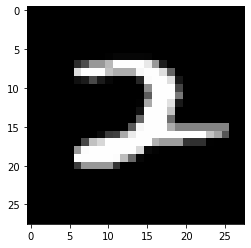

In [137]:
test_prediction(99, W1, b1, W2, b2)

### Running equation on test dataset
- 500 iterations with a learning rate of 10%

In [76]:
W1, b1, W2, b2 = gradient_descent(X_test, Y_test, 0.05, 20000)

Iteration:  0
[4 1 4 ... 4 6 4] [7 1 2 ... 2 7 1]
0.1105
Iteration:  100
[4 1 6 ... 6 6 4] [7 1 2 ... 2 7 1]
0.126
Iteration:  200
[4 1 6 ... 6 6 1] [7 1 2 ... 2 7 1]
0.1475
Iteration:  300
[4 1 6 ... 6 1 1] [7 1 2 ... 2 7 1]
0.1685
Iteration:  400
[6 1 6 ... 8 1 1] [7 1 2 ... 2 7 1]
0.1915
Iteration:  500
[6 1 6 ... 8 1 1] [7 1 2 ... 2 7 1]
0.2165
Iteration:  600
[6 1 6 ... 8 1 1] [7 1 2 ... 2 7 1]
0.2315
Iteration:  700
[6 1 6 ... 8 1 1] [7 1 2 ... 2 7 1]
0.2485
Iteration:  800
[6 1 6 ... 8 1 1] [7 1 2 ... 2 7 1]
0.2645
Iteration:  900
[6 1 6 ... 8 1 1] [7 1 2 ... 2 7 1]
0.278
Iteration:  1000
[6 1 6 ... 8 1 1] [7 1 2 ... 2 7 1]
0.2865
Iteration:  1100
[6 1 6 ... 8 1 1] [7 1 2 ... 2 7 1]
0.2965
Iteration:  1200
[6 1 6 ... 6 1 1] [7 1 2 ... 2 7 1]
0.3035
Iteration:  1300
[6 1 6 ... 2 1 1] [7 1 2 ... 2 7 1]
0.3185
Iteration:  1400
[6 1 6 ... 2 1 1] [7 1 2 ... 2 7 1]
0.331
Iteration:  1500
[6 1 6 ... 2 1 1] [7 1 2 ... 2 7 1]
0.3445
Iteration:  1600
[6 1 6 ... 2 1 1] [7 1 2 ... 2 7 1]
0.

Iteration:  13900
[3 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.842
Iteration:  14000
[3 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.8425
Iteration:  14100
[3 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.8425
Iteration:  14200
[3 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.8435
Iteration:  14300
[3 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.8445
Iteration:  14400
[3 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.845
Iteration:  14500
[3 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.8465
Iteration:  14600
[3 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.8475
Iteration:  14700
[7 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.8495
Iteration:  14800
[7 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.85
Iteration:  14900
[7 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.851
Iteration:  15000
[7 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.8525
Iteration:  15100
[7 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.8525
Iteration:  15200
[7 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.853
Iteration:  15300
[7 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.8535
Iteration:  15400
[7 1 2 ... 2 7 1] [7 1 2 ... 2 7 1]
0.854
Iteration:  15500
[7 1 2 ... 2 

## Out of sample test results
- After 20,000 iterations in the test sample with a learning rate of .05 we get an accuracy of 87.55%